Saved transparent contour 1 to contour_output/card05_01_contour_1.png
Saved transparent contour 2 to contour_output/card05_01_contour_2.png
Saved transparent contour 3 to contour_output/card05_01_contour_3.png
Saved transparent contour 4 to contour_output/card05_01_contour_4.png
Saved transparent contour 5 to contour_output/card05_01_contour_5.png
Saved transparent contour 6 to contour_output/card05_01_contour_6.png
Saved transparent contour 7 to contour_output/card05_01_contour_7.png
Saved transparent contour 8 to contour_output/card05_01_contour_8.png
Saved transparent contour 9 to contour_output/card05_01_contour_9.png
There are 9 objects detected on card05_01.tif, with a minimum size of 200.0
The threshold area is 127.63375000000002


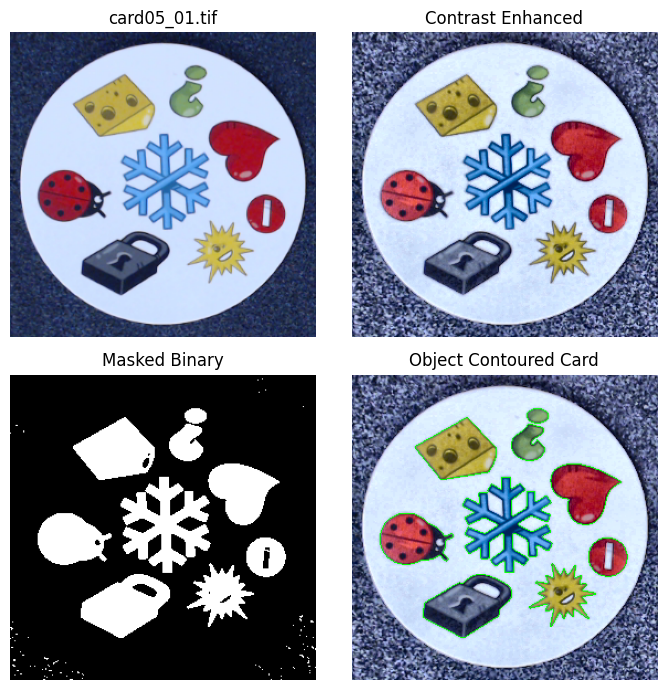

Saved transparent contour 1 to contour_output/card07_01_contour_1.png
Saved transparent contour 2 to contour_output/card07_01_contour_2.png
Saved transparent contour 3 to contour_output/card07_01_contour_3.png
Saved transparent contour 4 to contour_output/card07_01_contour_4.png
Saved transparent contour 5 to contour_output/card07_01_contour_5.png
Saved transparent contour 6 to contour_output/card07_01_contour_6.png
Saved transparent contour 7 to contour_output/card07_01_contour_7.png
Saved transparent contour 8 to contour_output/card07_01_contour_8.png
Saved transparent contour 9 to contour_output/card07_01_contour_9.png
Saved transparent contour 10 to contour_output/card07_01_contour_10.png
Saved transparent contour 11 to contour_output/card07_01_contour_11.png
There are 11 objects detected on card07_01.tif, with a minimum size of 16.0
The threshold area is 15.758750000000003


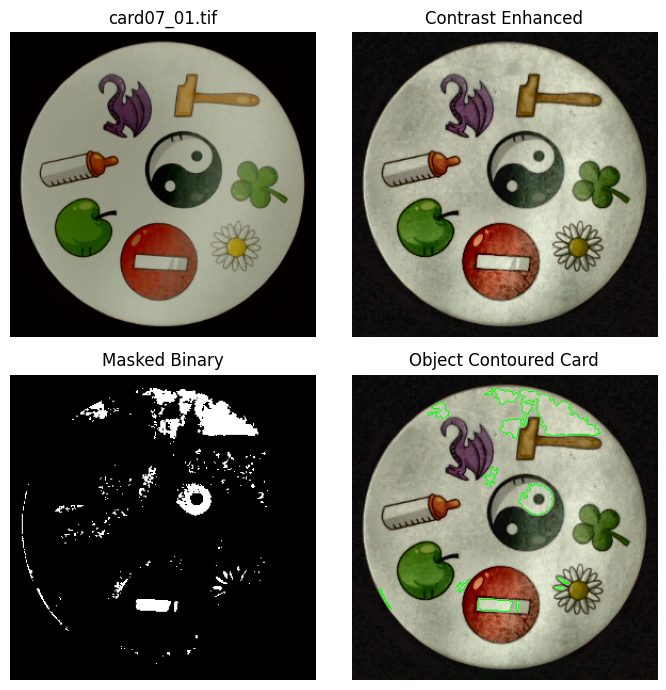

Saved transparent contour 1 to contour_output/card09_001_contour_1.png
Saved transparent contour 2 to contour_output/card09_001_contour_2.png
Saved transparent contour 3 to contour_output/card09_001_contour_3.png
Saved transparent contour 4 to contour_output/card09_001_contour_4.png
Saved transparent contour 5 to contour_output/card09_001_contour_5.png
Saved transparent contour 6 to contour_output/card09_001_contour_6.png
Saved transparent contour 7 to contour_output/card09_001_contour_7.png
Saved transparent contour 8 to contour_output/card09_001_contour_8.png
Saved transparent contour 9 to contour_output/card09_001_contour_9.png
There are 9 objects detected on card09_001.tif, with a minimum size of 5842.0
The threshold area is 1296.0000000000002


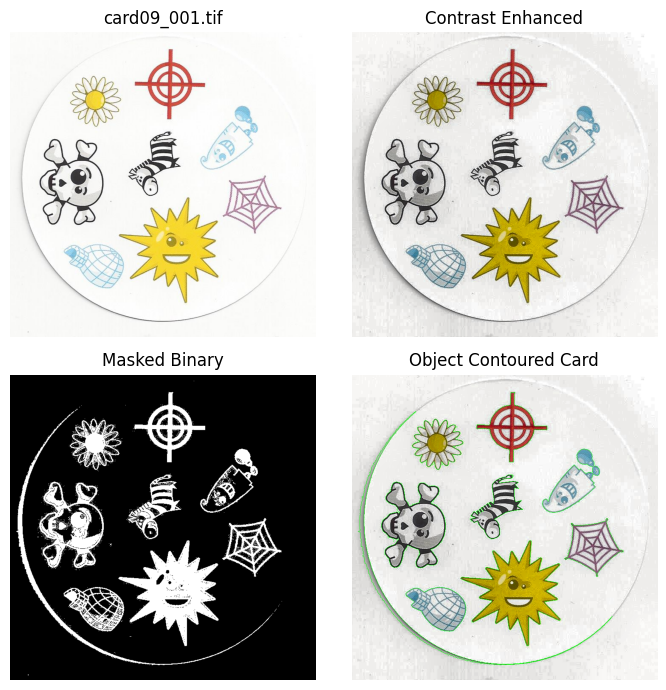

3


In [7]:
import cv2
import imutils
import os
import matplotlib.pyplot as plt
import numpy as np

output_directory = "contour_output"  # Directory to save the images
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist
def contrast_enhancement(img, clipLimit):
  """
  Converts input image into a contrast enhanced version by
  converting the image into the LAB color space, applying
  contrast limited adaptive histogram equalization with a 
  clip limit parameter to the lightness channel of LAB. This 
  effectively darkens the image while retaining the other data.

  Args:
    img: a 3D array with BGR image data
    clipLimit: a float **** lowkey i do not know what clipLimit is ****
  Returns:
    A contrast enhanced 3D array with RGB image data
  """
  # converting to LAB color space
  lab= cv2.cvtColor(img.copy(), cv2.COLOR_BGR2LAB)
  l_channel, a, b = cv2.split(lab)

  # Applying CLAHE to L-channel
  clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  # merge the CLAHE enhanced L-channel with the a and b channel
  limg = cv2.merge((cl,a,b))
  enhanced_RGB = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

  return enhanced_RGB

def find_object_contours(img, sym_card_size_ratio, binary_threshold):
  """
  Takes a card image and finds the outermost contours above a certain area
  threshold excluding the card itself.

  Args:
    img: the image itself, as an openCV output. 3D array with 3 color channels
    sym_card_size_ratio: a float which controls the min size a symbol has to be 
      to qualify as an object. for example, 1/20 would mean the symbol is 1/20th 
      the size of the full card (this could be wrong lol)
    binary_threshold: an integer binary threshold for the conversion to a binary 
      image from a grayscaled version of img
  Returns:
    card_mask: a 2D black and white numpy array, where 255 is white and 0 is black.
      intended to be the filled in outline of the card (basically a circle)
    masked_binary: a 2D black and white numpy array, where 255 is white and 0 is black.
      intended to contain the just the objects on a black background
    object_contours: a list of contours which exceed the area threshold and are the
      the direct children of the card outline
  """
  gray_enhanced = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  _, binary= cv2.threshold(gray_enhanced, binary_threshold, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # create a mask to exclude the card
  card_mask = np.ones_like(gray_enhanced, dtype=np.uint8) * 255  # Start with a white mask
  card_contour = max(contours, key=cv2.contourArea)
  cv2.drawContours(card_mask, [card_contour], -1, color=0, thickness=cv2.FILLED)

  # Here we calculate the min required symbol size for size thresholding. With 1/20 for deck 2, 
  # this also removes the little lines coming off the bomb and some sections of the smaller splats
  threshold_area = cv2.contourArea(card_contour)*(sym_card_size_ratio**2)

  # apply the mask to the binary image
  masked_binary = cv2.bitwise_not(binary, binary, mask=card_mask)
  masked_binary = cv2.bitwise_not(masked_binary)
  outer_contours, _ = cv2.findContours(masked_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # area thresholding
  object_contours = [
     contour for contour in outer_contours if cv2.contourArea(contour) > threshold_area
     ]

  return [card_mask, masked_binary, object_contours, threshold_area]
   

# For dobble deck 2, clipLimit 5.0, sym_card_size_ratio 1/20, binary_thresh 190
# card 35 in deck 2 has a really small splatter that we need to deal with -- it requires 1/25
# card 27 in deck 2's moon is stupidly close to the fire which might fuck with the distance thresholding idea we had
# card 29 in deck 2's daisy is a little screwed up

# For dobble deck 4 card 02, the web and the pencil are very different and it's hard to find a threshold that works for both

card_directory = "dobble_deck07_cards_55"
clipLimit = 5.0
# This parameter controls the min size a symbol has to be to qualify as an object
# 1/20 would mean the symbol is 1/20th the size of the full card
sym_card_size_ratio = 1/20
binary_thresh = 190

counter = 0
image_not_found_cnt = 0
# for file in os.listdir(card_directory):
for card_idx in ["05_", "07_", "09_0"]:
  VISUALIZE = False

  # **** uncomment this and the break statement at the bottom to test just one card ****
  # card_idx = "06"
  file = "card" + card_idx + "01.tif"
  VISUALIZE = True

  # load image
  image = cv2.imread(os.path.join(file))
  # this is because my mac is doing stupid shit with .ds store or smth
  if image is None:
      image_not_found_cnt += 1
      if image_not_found_cnt > 1:
        raise FileNotFoundError(f"Could not load image: {file}")
      else:
        continue
      

  # enhance the contrast in the lightness color space
  enhanced_RGB = contrast_enhancement(image, clipLimit)

  # draw the smaller contours for visualization
  [card_mask, masked_binary, object_contours, threshold_area
    ] = find_object_contours(enhanced_RGB.copy(), sym_card_size_ratio, binary_thresh)
  contoured_output_image = enhanced_RGB.copy()
  cv2.drawContours(contoured_output_image, object_contours, -1, (0, 255, 0), thickness=1)

  for i, contour in enumerate(object_contours):
    x, y, w, h = cv2.boundingRect(contour)
    # Crop the ROI from the original image
    roi = enhanced_RGB[y:y+h, x:x+w]
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(mask, [contour - [x, y]], -1, 255, thickness=cv2.FILLED)
    roi_masked = cv2.bitwise_and(roi, roi, mask=mask)
    # Convert to BGRA (add alpha channel)
    roi_bgra = cv2.cvtColor(roi_masked, cv2.COLOR_RGB2BGRA)
    roi_bgra[:, :, 3] = mask  # Set alpha channel based on the mask
    # Save the ROI as a PNG with transparency
    contour_filename = f"{file.split('.')[0]}_contour_{i+1}.png"
    contour_path = os.path.join(output_directory, contour_filename)
    cv2.imwrite(contour_path, roi_bgra)
    print(f"Saved transparent contour {i+1} to {contour_path}")


  # if it messed up and found not 8 symbols
  if len(object_contours) != 8:
    counter += 1
    VISUALIZE = True
  
  if VISUALIZE:
    contour_areas = [cv2.contourArea(contour) for contour in object_contours]
    print(f"There are {len(object_contours)} objects detected on {file}, with a minimum size of {min(contour_areas)}")
    print(f"The threshold area is {threshold_area}")

    fig, axs = plt.subplots(2, 2, figsize=(7, 7))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    axs[0,0].imshow(image_rgb)
    axs[0,0].set_title(file)
    axs[0,0].axis("off")

    axs[0,1].imshow(enhanced_RGB, cmap="gray")
    axs[0,1].set_title(f'Contrast Enhanced')
    axs[0,1].axis("off")

    axs[1,0].imshow(masked_binary, cmap="gray")
    axs[1,0].set_title(f"Masked Binary")
    axs[1,0].axis("off")

    axs[1,1].imshow(contoured_output_image, cmap="gray")
    axs[1,1].set_title(f'Object Contoured Card')
    axs[1,1].axis("off")

    plt.tight_layout()
    plt.show()

print(counter)

In [25]:
symbol_list = [
    'anchor', 'apple', 'bird', 'bomb', 'bottle', 'cactus', 
    'candle', 'car', 'carrot', 'cat', 'cheese', 'clock', 
    'clover', 'clown', 'daisy', 'dinosaur', 'do_not_enter', 
    'dog', 'dolphin', 'dragon', 'droplet', 'exclamation', 'eye', 
    'fire', 'ghost', 'hand', 'heart', 'ice', 'igloo', 'key', 
    'knight', 'ladybug', 'leaf', 'lightbulb', 'lightning', 
    'lips', 'lock', 'mallet', 'man', 'moon', 'pencil', 
    'question', 'scissors', 'skull', 'snowflake', 'snowman', 
    'spider', 'splat', 'sun', 'sunglasses', 'target', 'treble', 
    'tree', 'turtle', 'web', 'yin_yang', 'zebra'
    ]
for symbol in symbol_list:
    os.mkdir("deck-01/" + symbol)